# Breast Cancer Detection
### *Mammography images classification*

DATASET (InBreast): https://www.kaggle.com/martholi/inbreast

## Importing packages

In [1]:
import xlrd
import csv
import os
from os import path
import glob

import numpy as np
import pandas as pd

import cv2 as cv

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img

import pydicom
import dicom2nifti
from pydicom.data import get_testdata_files

from sklearn.model_selection import train_test_split

## Loading data

In [2]:
# *Script for downloading and extraction of the files

In [3]:
dir_path = 'data/inBreast/INbreast_Release_1.0/'

In [4]:
labels_path = os.path.join(dir_path, 'INbreast.xls')

In [5]:
labels = pd.read_excel(labels_path, index_col=None)

In [6]:
labels.columns

Index(['Patient ID', 'Patient age', 'Laterality', 'View', 'Acquisition date',
       'File Name', 'ACR', 'Bi-Rads', 'Mass ', 'Micros', 'Distortion',
       'Asymmetry', 'Findings Notes (in Portuguese)', 'Other Notes',
       'Lesion Annotation Status', 'Pectoral Muscle Annotation',
       'Other Annotations'],
      dtype='object')

In [7]:
labels.head()

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,Mass,Micros,Distortion,Asymmetry,Findings Notes (in Portuguese),Other Notes,Lesion Annotation Status,Pectoral Muscle Annotation,Other Annotations
0,removed,removed,R,CC,201001.0,22678622.0,4,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN
1,removed,removed,L,CC,201001.0,22678646.0,4,3,X,NaN,NaN,NaN,nódulo,NaN,NaN,NaN,NaN
2,removed,removed,R,MLO,201001.0,22678670.0,4,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN
3,removed,removed,L,MLO,201001.0,22678694.0,4,3,X,NaN,NaN,NaN,nódulo,NaN,NaN,NaN,NaN
4,removed,removed,R,CC,201001.0,22614074.0,2,5,X,X,NaN,NaN,nódulo QSE + micros,NaN,NaN,NaN,NaN


In [8]:
labels = labels[labels['File Name'].notna()]

In [9]:
dicoms_path = dir_path + 'AllDICOMs'

In [10]:
labels['File ID'] = labels['File Name'].apply(lambda x: str(int(x)))
labels['DICOM Path'] = labels['File Name'].apply(lambda x: glob.glob(os.path.join(dicoms_path, str(str(int(x)) + '*')))[0])
labels.drop(['File Name'], axis = 1)

,Patient ID,Patient age,Laterality,View,Acquisition date,ACR,Bi-Rads,Mass,Micros,Distortion,Asymmetry,Findings Notes (in Portuguese),Other Notes,Lesion Annotation Status,Pectoral Muscle Annotation,Other Annotations,File ID,DICOM Path
0,removed,removed,R,CC,201001.0,4,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN,22678622,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
1,removed,removed,L,CC,201001.0,4,3,X,NaN,NaN,NaN,nódulo,NaN,NaN,NaN,NaN,22678646,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
2,removed,removed,R,MLO,201001.0,4,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN,22678670,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
3,removed,removed,L,MLO,201001.0,4,3,X,NaN,NaN,NaN,nódulo,NaN,NaN,NaN,NaN,22678694,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
4,removed,removed,R,CC,201001.0,2,5,X,X,NaN,NaN,nódulo QSE + micros,NaN,NaN,NaN,NaN,22614074,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,removed,removed,L,MLO,201001.0,2,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN,22613848,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
406,removed,removed,L,MLO,200802.0,4,2,NaN,X,NaN,NaN,micros,NaN,NaN,NaN,NaN,24055725,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
407,removed,removed,R,MLO,200802.0,4,2,NaN,X,NaN,NaN,micros,NaN,NaN,NaN,NaN,24055752,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
408,removed,removed,L,CC,200802.0,4,2,NaN,X,NaN,NaN,micros,NaN,NaN,NaN,NaN,24055779,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...


In [11]:
def find_id(fname):
    start = len(dicoms_path) + 1
    fname = fname[start:]
    pid = fname[fname.find('_')+1:]
    pid = pid[:pid.find('_')]
    return pid

In [12]:
labels['Patient ID'] = labels.apply(lambda x: find_id(x['DICOM Path']), axis=1)

In [13]:
labels.head()

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,Mass,Micros,Distortion,Asymmetry,Findings Notes (in Portuguese),Other Notes,Lesion Annotation Status,Pectoral Muscle Annotation,Other Annotations,File ID,DICOM Path
0,61b13c59bcba149e,removed,R,CC,201001.0,22678622.0,4,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN,22678622,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
1,61b13c59bcba149e,removed,L,CC,201001.0,22678646.0,4,3,X,NaN,NaN,NaN,nódulo,NaN,NaN,NaN,NaN,22678646,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
2,61b13c59bcba149e,removed,R,MLO,201001.0,22678670.0,4,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN,22678670,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
3,61b13c59bcba149e,removed,L,MLO,201001.0,22678694.0,4,3,X,NaN,NaN,NaN,nódulo,NaN,NaN,NaN,NaN,22678694,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
4,6bd24a0a42c19ce1,removed,R,CC,201001.0,22614074.0,2,5,X,X,NaN,NaN,nódulo QSE + micros,NaN,NaN,NaN,NaN,22614074,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...


In [14]:
# labels = labels.loc[labels['Laterality'] == 'L']

explain BI-Rads transformation

In [15]:
labels = labels.drop(['Patient age', 'Acquisition date', 'ACR', 'Distortion',
                      'Asymmetry', 'Findings Notes (in Portuguese)', 'Other Notes',
                      'Lesion Annotation Status', 'Pectoral Muscle Annotation',
                      'Other Annotations'], axis = 1)

In [16]:
labels

,Patient ID,Laterality,View,File Name,Bi-Rads,Mass,Micros,File ID,DICOM Path
0,61b13c59bcba149e,R,CC,22678622.0,1,NaN,NaN,22678622,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
1,61b13c59bcba149e,L,CC,22678646.0,3,X,NaN,22678646,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
2,61b13c59bcba149e,R,MLO,22678670.0,1,NaN,NaN,22678670,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
3,61b13c59bcba149e,L,MLO,22678694.0,3,X,NaN,22678694,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
4,6bd24a0a42c19ce1,R,CC,22614074.0,5,X,X,22614074,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
...,...,...,...,...,...,...,...,...,...
405,45c7f44839fd9e68,L,MLO,22613848.0,1,NaN,NaN,22613848,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
406,f0f1a133837b5137,L,MLO,24055725.0,2,NaN,X,24055725,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
407,f0f1a133837b5137,R,MLO,24055752.0,2,NaN,X,24055752,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
408,f0f1a133837b5137,L,CC,24055779.0,2,NaN,X,24055779,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...


In [17]:
labels.loc[(labels['Mass '] != 'X') & (labels['Micros'] == 'X')]

,Patient ID,Laterality,View,File Name,Bi-Rads,Mass,Micros,File ID,DICOM Path
8,97ec8cadfca70d32,L,MLO,50997434.0,2,NaN,X,50997434,data/inBreast/INbreast_Release_1.0/AllDICOMs/5...
10,97ec8cadfca70d32,L,CC,50997488.0,2,NaN,X,50997488,data/inBreast/INbreast_Release_1.0/AllDICOMs/5...
20,66adfbb4f19c76d2,R,CC,50998032.0,2,NaN,X,50998032,data/inBreast/INbreast_Release_1.0/AllDICOMs/5...
21,66adfbb4f19c76d2,L,MLO,50998059.0,5,NaN,X,50998059,data/inBreast/INbreast_Release_1.0/AllDICOMs/5...
22,66adfbb4f19c76d2,R,MLO,50998086.0,2,NaN,X,50998086,data/inBreast/INbreast_Release_1.0/AllDICOMs/5...
...,...,...,...,...,...,...,...,...,...
403,45c7f44839fd9e68,L,CC,22613796.0,2,NaN,X,22613796,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
406,f0f1a133837b5137,L,MLO,24055725.0,2,NaN,X,24055725,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
407,f0f1a133837b5137,R,MLO,24055752.0,2,NaN,X,24055752,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...
408,f0f1a133837b5137,L,CC,24055779.0,2,NaN,X,24055779,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...


In [18]:
def birads_to_class(df):
    
    df['Class'] = df.apply(lambda row: 'Normal' if str(row['Bi-Rads']) == '1' 
                                      else 'Benign Mass' if (str(row['Bi-Rads']) == '2' or str(row['Bi-Rads']) == '3') and row['Mass '] == 'X'
                                      else 'Benign Calcification' if (str(row['Bi-Rads']) == '2' or str(row['Bi-Rads']) == '3') and row['Micros'] == 'X' 
                                      else 'Malignant Mass' if row['Mass '] == 'X'
                                      else 'Malignant Calcification', axis=1)

    label = 'Normal', 'Benign Mass', 'Benign Calcification', 'Malignant Mass', 'Malignant Calcification'
    plt.figure(figsize = (8,8))
    plt.pie(labels.groupby('Class').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.show()

    one_hot = pd.get_dummies(df['Class'])
    df = df.drop(['Class', 'Bi-Rads'], axis = 1)
    df = df.join(one_hot)
    return df

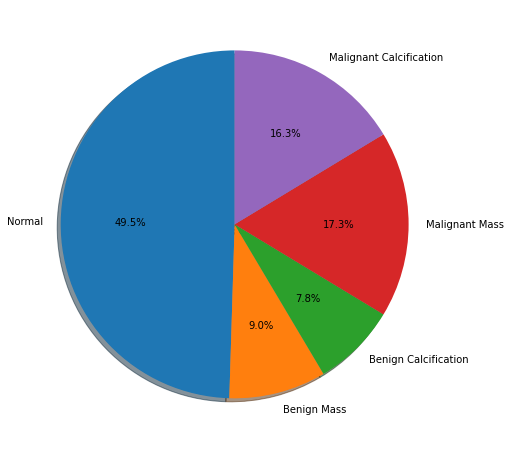

,Patient ID,Laterality,View,File Name,Mass,Micros,File ID,DICOM Path,Benign Calcification,Benign Mass,Malignant Calcification,Malignant Mass,Normal
0,61b13c59bcba149e,R,CC,22678622.0,NaN,NaN,22678622,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,0,0,0,0,1
1,61b13c59bcba149e,L,CC,22678646.0,X,NaN,22678646,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,0,1,0,0,0
2,61b13c59bcba149e,R,MLO,22678670.0,NaN,NaN,22678670,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,0,0,0,0,1
3,61b13c59bcba149e,L,MLO,22678694.0,X,NaN,22678694,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,0,1,0,0,0
4,6bd24a0a42c19ce1,R,CC,22614074.0,X,X,22614074,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,0,0,0,1,0


In [19]:
labels = birads_to_class(labels)
labels.head()

In [20]:
labels.columns

Index(['Patient ID', 'Laterality', 'View', 'File Name', 'Mass ', 'Micros',
       'File ID', 'DICOM Path', 'Benign Calcification', 'Benign Mass',
       'Malignant Calcification', 'Malignant Mass', 'Normal'],
      dtype='object')

In [21]:
labels['Benign Calcification'] = labels.apply(lambda row: 1 if row['Benign Mass'] == 1 and row['Micros'] == 'X' else row['Benign Calcification'], axis=1)
labels['Malignant Calcification'] = labels.apply(lambda row: 1 if row['Malignant Mass'] == 1 and row['Micros'] == 'X' else row['Malignant Calcification'], axis=1)

In [22]:
labels.loc[(labels['Mass '] != 'X') & (labels['Micros'] == 'X')]

,Patient ID,Laterality,View,File Name,Mass,Micros,File ID,DICOM Path,Benign Calcification,Benign Mass,Malignant Calcification,Malignant Mass,Normal
8,97ec8cadfca70d32,L,MLO,50997434.0,NaN,X,50997434,data/inBreast/INbreast_Release_1.0/AllDICOMs/5...,1,0,0,0,0
10,97ec8cadfca70d32,L,CC,50997488.0,NaN,X,50997488,data/inBreast/INbreast_Release_1.0/AllDICOMs/5...,1,0,0,0,0
20,66adfbb4f19c76d2,R,CC,50998032.0,NaN,X,50998032,data/inBreast/INbreast_Release_1.0/AllDICOMs/5...,1,0,0,0,0
21,66adfbb4f19c76d2,L,MLO,50998059.0,NaN,X,50998059,data/inBreast/INbreast_Release_1.0/AllDICOMs/5...,0,0,1,0,0
22,66adfbb4f19c76d2,R,MLO,50998086.0,NaN,X,50998086,data/inBreast/INbreast_Release_1.0/AllDICOMs/5...,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,45c7f44839fd9e68,L,CC,22613796.0,NaN,X,22613796,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,1,0,0,0,0
406,f0f1a133837b5137,L,MLO,24055725.0,NaN,X,24055725,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,1,0,0,0,0
407,f0f1a133837b5137,R,MLO,24055752.0,NaN,X,24055752,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,1,0,0,0,0
408,f0f1a133837b5137,L,CC,24055779.0,NaN,X,24055779,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,1,0,0,0,0


## Image preprocessing

In [326]:
def contrast(path):
    img = cv.imread(path, 0)
    flat = img.flatten()
    
    hist = get_histogram(flat, 257)
    cs = cumsum(hist)
    
    nj = (cs - cs.min()) * 255
    N = cs.max() - cs.min()


    cs = nj / N
    cs = cs.astype('uint8')
    
    img_new = cs[flat]
    img_new = np.reshape(img_new, img.shape)
    
    return img_new

In [327]:
def get_histogram(flat, bins):
    histogram = np.zeros(bins)

    for pixel in flat:
        histogram[pixel] += 1

    return histogram

In [328]:
def cumsum(a):
    a = iter(a)
    b = [next(a)]
    for i in a:
        b.append(b[-1] + i)
    return np.array(b)

In [26]:
png_path = dir_path + 'AllPNGs/'
pngs = []

def to_png(fname):
#     ds = pydicom.dcmread(fname)
#     arr = ds.pixel_array
    
#     old_min = 0
#     old_max = np.max(arr)
#     new_min = 0
#     new_max = 256
    
#     def scale(old_value):
#         return ((old_value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
    
#     newarr = np.vectorize(scale)(arr)
#     newarr = newarr.astype(int)

    new_path = str(png_path + fname[fname.rfind('/') + 1: - 4] + '.png')
    pngs.append(new_path)
    
#     matplotlib.image.imsave(new_path, newarr, cmap='gray')

In [27]:
for f in labels['DICOM Path'].tolist():
    to_png(f)

In [28]:
# for f in labels['Pect Rem'].tolist()
#     to_png(f)

In [29]:
labels['PNG Path'] = pngs

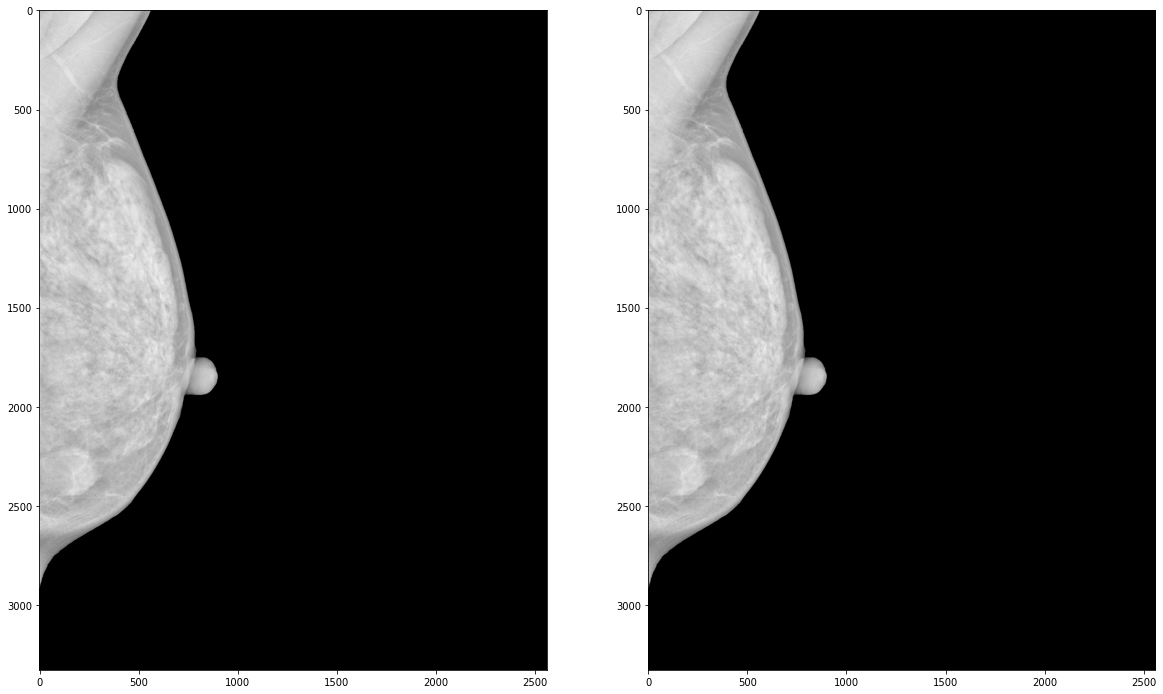

In [30]:
fig,ax = plt.subplots(1,2,figsize = (20, 20))

dic_file = labels['DICOM Path'][3]
png_file = labels['PNG Path'][3]

dic = pydicom.dcmread(dic_file).pixel_array
png = cv.imread(png_file)
# print

ax[0].imshow(dic, cmap='gray')
ax[1].imshow(png)

In [31]:
# ds = pydicom.dcmread('data/inbreast_tmp/ALL-IMGS/50998059.dcm')

In [32]:
# # Rename files:
# for count, filename in enumerate(os.listdir(img_path)): 
#         src = img_path + filename 
#         dst = img_path + filename[:filename.find('_')] + '.dcm'

#         os.rename(src, dst) 

data/inBreast/INbreast_Release_1.0/AllPNGs/53581033_4c341dad22471922_MG_L_CC_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/53581060_4c341dad22471922_MG_R_CC_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/50998607_cd12bc20b3d27d0b_MG_R_ML_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/50998661_cd12bc20b3d27d0b_MG_R_CC_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/22613848_45c7f44839fd9e68_MG_L_ML_ANON.png


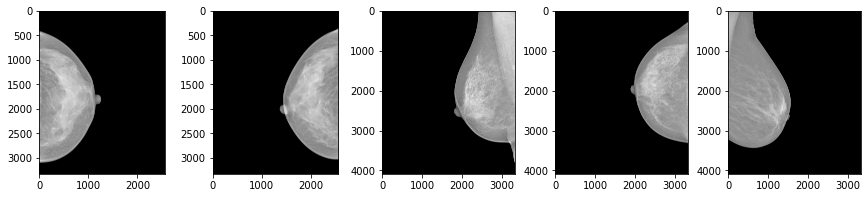

In [33]:
# NORMAL
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['Normal'] == 1]['PNG Path'][-5:]):
    print(idx)
    img = cv.imread(idx)
    ax[i].imshow(img)

data/inBreast/INbreast_Release_1.0/AllPNGs/22580367_5eae9beae14d26fd_MG_L_CC_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/22580419_5eae9beae14d26fd_MG_L_ML_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/20587758_81cd83d2f4d78528_MG_L_CC_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/20587810_81cd83d2f4d78528_MG_L_ML_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/20588680_036aff49b8ac84f0_MG_L_ML_ANON.png


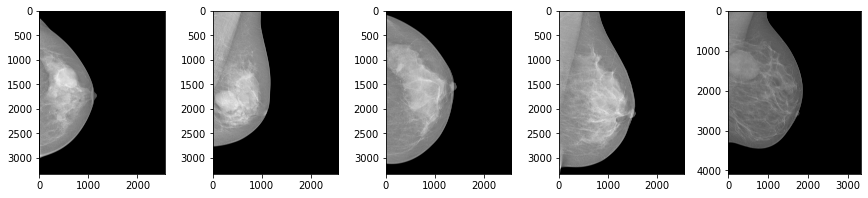

In [34]:
# BENIGN MASS
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[(labels['Benign Calcification'] == 0) & (labels['Benign Mass'] == 1)]['PNG Path'][-5:]):
    print(idx)
    img = cv.imread(idx)
    ax[i].imshow(img)

data/inBreast/INbreast_Release_1.0/AllPNGs/22613796_45c7f44839fd9e68_MG_L_CC_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/24055725_f0f1a133837b5137_MG_L_ML_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/24055752_f0f1a133837b5137_MG_R_ML_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/24055779_f0f1a133837b5137_MG_L_CC_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/24055806_f0f1a133837b5137_MG_R_CC_ANON.png


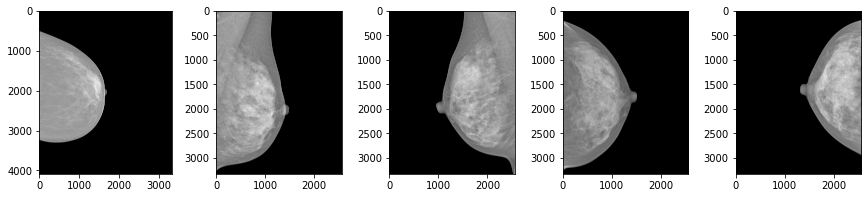

In [35]:
# BENIGN CALC
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[(labels['Benign Calcification'] == 1) & (labels['Benign Mass'] == 0)]['PNG Path'][-5:]):
    print(idx)
    img = cv.imread(idx)
    ax[i].imshow(img)

data/inBreast/INbreast_Release_1.0/AllPNGs/20588216_8d0b9620c53c0268_MG_L_ML_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/50996352_6aba0b402889a16f_MG_R_ML_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/50996406_6aba0b402889a16f_MG_R_CC_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/50994273_cc9e66c5b31baab8_MG_R_CC_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/50994354_cc9e66c5b31baab8_MG_R_ML_ANON.png


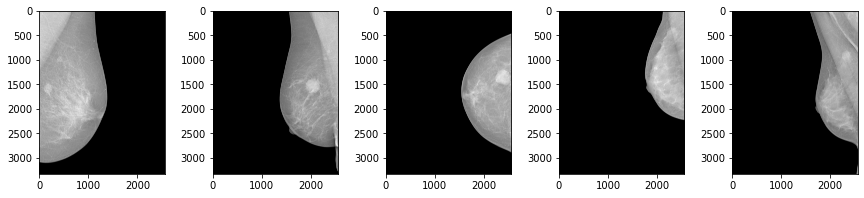

In [36]:
# MALIGNANT MASS
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[(labels['Malignant Calcification'] == 0) & (labels['Malignant Mass'] == 1)]['PNG Path'][-5:]):
    print(idx)
    img = cv.imread(idx)
    ax[i].imshow(img)

data/inBreast/INbreast_Release_1.0/AllPNGs/22670978_f571fd4e63c718e3_MG_L_CC_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/22671003_f571fd4e63c718e3_MG_L_ML_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/20587054_b6a4f750c6df4f90_MG_R_CC_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/20587080_b6a4f750c6df4f90_MG_R_ML_ANON.png
data/inBreast/INbreast_Release_1.0/AllPNGs/50998634_cd12bc20b3d27d0b_MG_L_CC_ANON.png


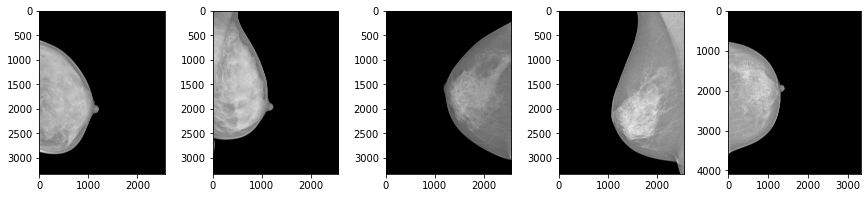

In [37]:
# MALIGNANT CALC
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[(labels['Malignant Calcification'] == 1) & (labels['Malignant Mass'] == 0)]['PNG Path'][-5:]):
    print(idx)
    img = cv.imread(idx)
    ax[i].imshow(img)

In [38]:
labels.loc[labels['File ID'] == '20587054']

,Patient ID,Laterality,View,File Name,Mass,Micros,File ID,DICOM Path,Benign Calcification,Benign Mass,Malignant Calcification,Malignant Mass,Normal,PNG Path
346,b6a4f750c6df4f90,R,CC,20587054.0,NaN,X,20587054,data/inBreast/INbreast_Release_1.0/AllDICOMs/2...,0,0,1,0,0,data/inBreast/INbreast_Release_1.0/AllPNGs/205...


# PECTORAL MUSCLE REMOVAL

In [39]:
from skimage import io
from skimage import color
import cv2 as cv

In [40]:
from skimage.feature import canny
from skimage.filters import sobel

def apply_canny(image):
    canny_img = canny(image, 4)
    return sobel(canny_img)

In [41]:
def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image

In [42]:
def right_orient_mammogram(image):
#     print('in right_orient')
    left_nonzero = cv.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
#         print('flip')
        image = cv.flip(image, 1)

    return image

In [43]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
#     print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
#         print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

In [44]:
def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 1500
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
#     print('\nShorlisted lines')
#     for i in shortlisted_lines:
#         print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
    return shortlisted_lines


In [45]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    print('pline', pectoral_line)
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

In [329]:
from matplotlib import pylab as pylab
def display_image(filename, orig_fname, save_to):
    print('start')
    image = read_image(filename)
    image_orig = read_image(orig_fname)
    canny_image = apply_canny(image)
    lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)
    
    fig, axes = plt.subplots(1, 4, figsize=(15,10))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Right-oriented mammogram')
    axes[0].imshow(image_orig, cmap=pylab.cm.gray)
    axes[0].axis('on') 
    
    axes[1].set_title('Contrasted Binarized mammogram')
    axes[1].imshow(image, cmap=pylab.cm.gray)
    axes[1].axis('on')
        
    axes[2].set_title('Shortlisted Hough Lines on Canny Edge Image')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    image_orig = read_image(orig_fname)
    rr, cc = remove_pectoral(shortlisted_lines)
    image_orig[rr, cc] = 0
    axes[3].set_title('Pectoral muscle removed')
    matplotlib.image.imsave(save_to, image_orig, cmap='gray')
    axes[3].imshow(image_orig, cmap=pylab.cm.gray)
    axes[3].axis('on') 
    print('finish')
    
    plt.show()

In [47]:
# def pect_removal(inp_img):
    
#     inp_img = cv2.imread(inp_img,0)
#     out_img = inp_img
#     out_img = right_orient_mammogram(out_img)
#     ret,thresh = cv2.threshold(img,107,255,cv2.THRESH_BINARY)
    
#     val = 1 - thresh
    
#     bw_img = thresh 
#     matplotlib.image.imsave('thresh.png', thresh, cmap='gray')
    
#     canny_image = apply_canny(out_img)
#     plt.imshow(bw_img, 'gray')
# #     plt.imshow(canny_image, 'gray')

# pect_removal('name.png')

In [48]:
# data/inBreast/INbreast_Release_1.0/PectRem/22614150_6bd24a0a42c19ce1_MG_L_ML_ANON-rem.png
# img = cv.imread('data/inBreast/INbreast_Release_1.0/AllPNGs/22614150_6bd24a0a42c19ce1_MG_L_ML_ANON.png',0)
# adapt_thresh = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
#             cv.THRESH_BINARY_INV,201,5)

# gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# blurred = cv.GaussianBlur(img, (3, 3), 3)

# adapt_thresh = cv.adaptiveThreshold(blurred, 255,
#                                     cv.ADAPTIVE_THRESH_MEAN_C,
#                                     cv.THRESH_BINARY_INV, 7, -2)
# img = read_image('data/inBreast/INbreast_Release_1.0/AllPNGs/22614150_6bd24a0a42c19ce1_MG_L_ML_ANON.png')
# img_l = img.tolist()
# # m = img_l[int(len(img_l)/2)][int(len(img_l[0])/3*1)]
# m = np.mean([max(i[:10]) for i in img_l[:10]])
# print(m)

# ret,threshn = cv.threshold(img, m,1,cv.THRESH_BINARY)
# ret,thresh2 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
# ret,thresh3 = cv.threshold(img,127,255,cv.THRESH_TRUNC)
# ret,thresh4 = cv.threshold(img,127,255,cv.THRESH_TOZERO)
# ret,thresh5 = cv.threshold(img,127,255,cv.THRESH_TOZERO_INV)

# titles = ['Original Image','adapt','BINARY','TRUNC','TOZERO','TOZERO_INV']
# images = [img, adapt_thresh, threshn, thresh2, thresh3, thresh4]

# fig = plt.figure()
# fig.set_figheight(15)
# fig.set_figwidth(15)

# for i in range(6):
#     plt.subplot(3,2,i+1),plt.imshow(images[i],'gray')
#     plt.title(titles[i])
#     plt.xticks([]),plt.yticks([])

# plt.show()

In [50]:
# display_image('name7_thresh.png', 'data/inBreast/INbreast_Release_1.0/AllPNGs/22613848_45c7f44839fd9e68_MG_L_ML_ANON.png', 'tmp.png')

In [51]:
# import cv2 as cv
# import numpy as np
# img = cv.imread('contrast_pect_removed.png',0)
# kernel = np.ones((5,5),np.uint8)

# path.exists("guru99.txt")

In [52]:
pect_rem_dir = 'data/inBreast/INbreast_Release_1.0/PectRem/'

In [53]:
def find_pect_rem_path(p):
    found = glob.glob(str(pect_rem_dir + p[p.rfind('/')+1:-4] + '*'))
    if len(found) == 0:
        return None
    return found[0]

In [54]:
labels['Pect Rem'] = labels['PNG Path'].apply(lambda p: find_pect_rem_path(p))

In [55]:
labels['drop'] = labels.apply(lambda row: 1 if row['View'] == 'MLO' and row['Pect Rem'] == None else 0, axis = 1)

In [56]:
labels = labels.drop(labels[labels['drop'] == 1].index)
labels = labels.drop(['drop'], axis = 1)

save_to:  name1-rem.png
start


<ipython-input-41-36f484922f9f>:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = color.rgb2gray(image)


pline {'dist': 580.5691318327972, 'angle': 28.659217877094957, 'point1': [0, 1210.5302241391498], 'point2': [2560, -3473.317061236522]}
finish


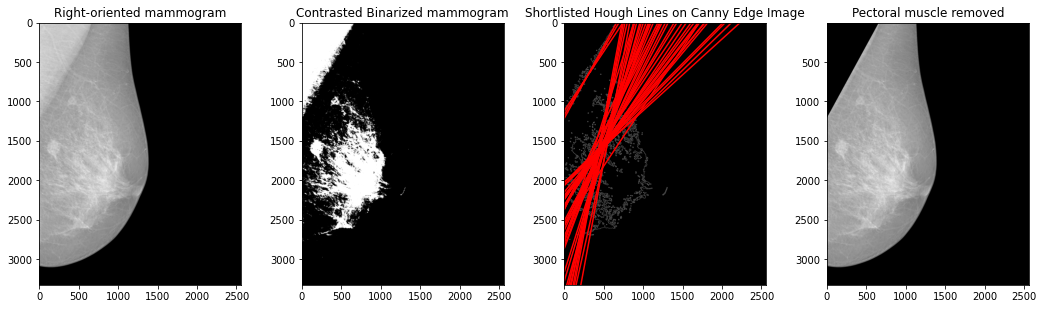

In [335]:
pect_rem_dir_path = 'data/inBreast/INbreast_Release_1.0/PectRem/'
to_rem = labels.loc[labels['View'] == 'MLO']
failed = []

count = 1
for png_path in to_rem['PNG Path']:
#     demo:
    png_path = 'name1.png'
    
    if not count:
        break
        
    img = cv.imread(png_path, 0)
#     img = read_image(png_path)

#     find treshold
#     img_l = img.tolist()
# #     m = img_l[int(len(img_l)/2)][100]
#     m = np.mean([np.mean([k for k in i[:10] if k]) for i in img_l[:10]])
#     print(m)
    
#     save_to = os.path.join(pect_rem_dir_path, str(png_path[png_path.rfind('/')+1:-4] + '-rem.png'))
    save_to = 'name1-rem.png'
    
#     if save_to in not_needed or save_to in to_check:
#         img_clone = img.copy()
#         matplotlib.image.imsave(save_to, img_clone, cmap='gray')
#         continue
#     else:
#         continue
        
    if path.exists(save_to):
        print('exists')
        continue
    elif (save_to in to_check):
        print('to check')
        
    print('save_to: ', save_to)
    
    ret, thresh = cv.threshold(img, 180, 255,cv.THRESH_BINARY)
#     print(png_path)
#     thresh = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
#             cv.THRESH_BINARY_INV,101,5)
    
#     thresh = to_tresh(png_path)
    matplotlib.image.imsave('tmp/thresh.png', thresh, cmap='gray')
    
    try:
        display_image('tmp/thresh.png', png_path, save_to)
    except:
        failed.append(png_path)
        print(png_path)
        continue
        
    count -= 1

In [334]:
not_needed = ['data/inBreast/INbreast_Release_1.0/PectRem/50993922_de5e8d61e501a71b_MG_R_ML_ANON-rem.png', 
              'data/inBreast/INbreast_Release_1.0/PectRem/50993895_de5e8d61e501a71b_MG_L_ML_ANON-rem.png', 
              'data/inBreast/INbreast_Release_1.0/PectRem/50993787_de5e8d61e501a71b_MG_L_ML_ANON-rem.png', 
              'data/inBreast/INbreast_Release_1.0/PectRem/53580831_51bec6477a7898b9_MG_R_ML_ANON-rem.png',
              'data/inBreast/INbreast_Release_1.0/PectRem/53580804_51bec6477a7898b9_MG_L_ML_ANON-rem.png', 
              'data/inBreast/INbreast_Release_1.0/PectRem/53582764_465aa5ec1b59efc6_MG_R_ML_ANON-rem.png']

In [333]:
to_check = ['data/inBreast/INbreast_Release_1.0/PectRem/50998322_1e4b534393d18753_MG_R_ML_ANON-rem.png',
            'data/inBreast/INbreast_Release_1.0/PectRem/20588680_036aff49b8ac84f0_MG_L_ML_ANON-rem.png', #(defin on muscle)
            'data/inBreast/INbreast_Release_1.0/PectRem/50994354_cc9e66c5b31baab8_MG_R_ML_ANON-rem.png', 
            'data/inBreast/INbreast_Release_1.0/PectRem/50998204_f34ee0ab6591b792_MG_R_ML_ANON-rem.png', 
            'data/inBreast/INbreast_Release_1.0/PectRem/53580831_51bec6477a7898b9_MG_R_ML_ANON-rem.png',
            'data/inBreast/INbreast_Release_1.0/PectRem/53580804_51bec6477a7898b9_MG_L_ML_ANON-rem.png',
            'data/inBreast/INbreast_Release_1.0/PectRem/50998204_f34ee0ab6591b792_MG_R_ML_ANON-rem.png',
            'data/inBreast/INbreast_Release_1.0/PectRem/27829188_fbb55bf7fff48540_MG_R_ML_ANON-rem.png',
            'data/inBreast/INbreast_Release_1.0/PectRem/53586388_dda3c6969a34ff8e_MG_R_ML_ANON-rem.png', 
            'data/inBreast/INbreast_Release_1.0/PectRem/53582395_3f0db31711fc9795_MG_L_ML_ANON-rem.png'] #(defin on muscle)

## Masks extraction

In [58]:
import xml.etree.ElementTree as ET
import glob
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box

In [59]:
def parse_xml(path):
    dct = {}
    ind = 0
    tree = ET.parse(path)
    root = tree.getroot()
    array = root[0][1][0][-1]
    
    for entry in array:
        dct[ind] = [None, None]
        name = 0
        pt = 0

        for child in entry:
            if name:
                dct[ind][0] = child.text
                name = 0
            if child.text == 'Name':
                name = 1
            if pt:
                dct[ind][1] = []

                for stri in child:
                    t = stri.text
                    tup = (float(t[1:t.find(',')]), float(t[t.find(',')+2:-1]))
                    dct[ind][1].append(tup)
                pt = 0
            if child.text == 'Point_px':
                pt = 1
        ind += 1
        
    return dct

In [60]:
xml_dir_path = 'data/inBreast/INbreast_Release_1.0/AllXML/'
rois_pathes = glob.glob(str(xml_dir_path + '*.xml'))

In [61]:
rois = pd.DataFrame()
ids = []
for p in rois_pathes:
    ids.append(p[p.rfind('/')+1:-4])
rois['ID'] = ids

In [62]:
regs = []
for p in rois_pathes:
    regs.append(parse_xml(p))
rois['pts'] = regs

In [63]:
rois

,ID,pts
0,50997651,"{0: ['Calcification', [(1457.380005, 1854.5899..."
1,50999459,"{0: ['Mass', [(967.768982, 1645.619995), (959...."
2,53580638,"{0: ['Calcification', [(2731.810059, 3544.9699..."
3,24065434,"{0: ['Calcification', [(1038.650024, 3287.0300..."
4,51049462,"{0: ['Calcification', [(1311.119995, 2360.8798..."
...,...,...
338,50996228,"{0: ['Calcification', [(162.764008, 2747.28002..."
339,22427705,"{0: ['Calcification', [(306.131958, 1878.98742..."
340,24065734,"{0: ['Calcification', [(1020.109985, 2109.6201..."
341,53587131,"{0: ['Calcification', [(805.182007, 2901.18994..."


## Patch extraction

In [64]:
def sliding_window(image, stepSize, windowSize):
    windows = []
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            windows.append((x, y, image[y:y + windowSize[1], x:x + windowSize[0]]))
    return windows

In [65]:
def filter_mass_patches(patches, mass_polys):
    treshold = 0.25
    filtered = {'mass': [], 'norm': []}
    for mass in mass_polys:
        for p in patches:
            patch_poly = box(p[0], p[1] - 255, p[0] + 255, p[1])
            intersection = patch_poly.intersection(mass).area
            if intersection > 0 and 0.9 >= intersection/(256*256) >=  treshold:
                if p not in filtered['mass']:
                    filtered['mass'].append(p)                
            elif intersection == 0:
                if p not in filtered['norm']:
                    filtered['norm'].append(p)
    return filtered

In [66]:
def filter_calc_patches(patches, calc_polys):
    calc_polys = [_ for _ in calc_polys if _]
    if not len(calc_polys):
        return {'calc': [], 'norm': []}
    filtered = {'calc': [], 'norm': []}
    for calc in calc_polys:
        for p in patches:
            patch_poly = box(p[0], p[1] - 255, p[0] + 255, p[1])
            if patch_poly.contains(calc):
                if p in filtered['norm']:
                    filtered['norm'].remove(p)
                if p not in filtered['calc']:
                    filtered['calc'].append(p)
            elif patch_poly.intersects(calc):
                if p in filtered['norm']:
                    filtered['norm'].remove(p)
                continue
            else:
                 if p not in filtered['norm']:
                    filtered['norm'].append(p)
    return filtered

In [67]:
def filter_patches(patches):
    filtered = []
    threshold = 0.02
    
    x = 256
    y = 256
    
    for p in patches:
        if not ((1 - (np.count_nonzero(p[2])/(x*y)) > threshold)):
            filtered.append(p)
    return filtered

In [102]:
def extract_abn(row):
    
    try:
        patches_dir = 'data/inBreast/INbreast_Release_1.0/AllPatches/'

        if row['Benign Mass']:
            mam_class = 2
        elif row['Benign Calcification']:
            mam_class = 3
        elif row['Malignant Mass']:
            mam_class = 4
        else:
            mam_class = 5

        if row['View'] == 'CC':
            png_path = row['PNG Path']
        elif row['Pect Rem']:
            png_path = row['Pect Rem']
        else:
            print(row['PNG Path'])
            return



        patches_dir += png_path[png_path.rfind('/')+1:-4] + '/'
        if not (os.path.exists(patches_dir)):
            os.mkdir(patches_dir)
        print(patches_dir)

        patch_df = pd.DataFrame()

        image = read_image(png_path)

        patches = sliding_window(image, 128, (256, 256))

        file_ID = row['File ID']
        abn_mass = [Polygon(pts[1]) for pts in rois.loc[rois['ID'] == file_ID]['pts'].tolist()[0].values() if pts[0] == 'Mass']
        abn_calc = [Polygon(pts[1]) if (pts[0] == 'Calcification' and len(pts[1]) > 1) 
                    else Point(pts[1]) if (pts[0] == 'Calcification' and len(pts[1]) == 1) else None 
                    for pts in rois.loc[rois['ID'] == file_ID]['pts'].tolist()[0].values()]

        mass_patches = []
        for mass in abn_mass:
            if not mass:
                break

            x = int(mass.centroid.coords[0][0])
            y = int(mass.centroid.coords[0][1])

            if x > 256:
                x -= 256
            else:
                x = 0
            if y > 256:
                y -= 256
            else:
                y = 0
            wsize = 256

            mass_patches.append((x, y, image[y:y + wsize, x:x + wsize]))
            mass_patches.append((x+256, y, image[y:y + wsize, x:x + wsize]))
            mass_patches.append((x, y+256, image[y:y + wsize, x:x + wsize]))
            mass_patches.append((x+256, y+256, image[y:y + wsize, x:x + wsize]))
            mass_patches.append((x+128, y+128, image[y:y + wsize, x:x + wsize]))

        calc_patches = []
        for calc in abn_calc:
            if not calc:
                break            
            x = int(calc.centroid.coords[0][0])
            y = int(calc.centroid.coords[0][1])

            if x > 128:
                x -= 128
            else:
                x = 0
            if y > 128:
                y -= 128
            else:
                y = 0

            wsize = 256
            calc_patches.append((x, y, image[y:y + wsize, x:x + wsize]))

        patches = filter_patches(patches)
        print('overall patches found: ', len(patches))
    #     print('mass: ', abn_mass)

        filtered_mass_patches = filter_mass_patches(patches, abn_mass)
        filtered_mass_patches['mass'].extend(filter_mass_patches(mass_patches, abn_mass)['mass'])
    #     print('filtered mass patches: ', len(filtered_mass_patches))
    #     print('mass patches: ', len(filtered_mass_patches['mass']))
        filtered_calc_patches = filter_calc_patches(patches, abn_calc)
        filtered_calc_patches['calc'].extend(calc_patches)

        filtered_patches = {'mass': filtered_mass_patches['mass'], 'calc': filtered_calc_patches['calc'], 
                            'norm': filtered_mass_patches['norm']}

        for p in filtered_calc_patches['norm']:
            if p not in filtered_patches['norm']:
                filtered_patches['norm'].append(p)

        for p in filtered_patches['mass']:
            if p in filtered_patches['calc']:
                filtered_patches['mass'].remove(p)
                filtered_patches['calc'].remove(p)


        pid = row['Patient ID']    

        filtered_patches['mass'] = [_ for _ in filtered_patches['mass'] if _]
    #     print('len mass: ',  len(filtered_patches['mass']))
        filtered_patches['calc'] = [_ for _ in filtered_patches['calc'] if _]
    #     print('len calc: ',  len(filtered_patches['calc']))
        filtered_patches['norm'] = [_ for _ in filtered_patches['norm'] if _]
    #     print('len norm: ',  len(filtered_patches['norm']))


        print('norm patches: ', len(filtered_patches['norm']))
        print('mass patches: ', len(filtered_patches['mass']))
        print('calc patches: ', len(filtered_patches['calc']))

        arr = filtered_patches['mass'].copy()
        arr.extend(filtered_patches['calc'])
        arr.extend(filtered_patches['norm'])
        x_start = [p[0] for p in arr]
        y_start = [p[1] for p in arr]

        count = 0 
        names = []
        for im in arr:
            name = patches_dir + pid + '-' + str(count) + '.png'
            names.append(name)
            count += 1
            matplotlib.image.imsave(name, im[2], cmap='gray')


        if mam_class <= 3:
            patch_class = [2 for i in range(len(filtered_patches['mass']))]
            patch_class.extend([3 for i in range(len(filtered_patches['calc']))])
            patch_class.extend([1 for i in range(len(filtered_patches['norm']))])
        else:
            patch_class = [4 for i in range(len(filtered_patches['mass']))]
            patch_class.extend([5 for i in range(len(filtered_patches['calc']))])
            patch_class.extend([1 for i in range(len(filtered_patches['norm']))])

    #     print(len(patch_class))
    #     print(patch_class)

        patient_class = mam_class = [mam_class for _ in range(len(names))]

        patch_df['File Name'] = names
        patch_df['File ID'] = [row['File ID'] for _ in range(len(names))]
        patch_df['Patient ID'] = [pid for _ in range(len(names))]
        patch_df['Patch Class'] = patch_class
        patch_df['Patient Class'] = patient_class
        patch_df['Mam Class'] = mam_class
        patch_df['PNG Path'] = [row['PNG Path'] for _ in range(len(names))] 
        patch_df['x_start'] = x_start
        patch_df['y_start'] = y_start
        
    except:
        print('fail', row['File ID'])
        return

    return patch_df

In [103]:
def extract_healthy(row):
    try:
        patches_dir = 'data/inBreast/INbreast_Release_1.0/AllPatches/'

        if row['View'] == 'CC':
            png_path = row['PNG Path']
        elif row['Pect Rem']:
            png_path = row['Pect Rem']
        else:
            print(row['PNG Path'])
            return   

        patches_dir += png_path[png_path.rfind('/')+1:-4] + '/'
        if not (os.path.exists(patches_dir)):
            os.mkdir(patches_dir)

        patch_df = pd.DataFrame()

        count = 0 
        names = []

        image = read_image(png_path)

        patches = sliding_window(image, 128, (256, 256))

        filtered_patches = filter_patches(patches)

        x_start = [p[0] for p in filtered_patches]
        y_start = [p[1] for p in filtered_patches]
        arr = [p[2] for p in filtered_patches]   

        pid = row['Patient ID']    

        for im in arr:
            name = patches_dir + pid + '-' + str(count) + '.png'
            names.append(name)
            count += 1
            matplotlib.image.imsave(name, im, cmap='gray')

        patch_class = patient_class = mam_class = [1 for _ in range(len(names))]

        patch_df['File Name'] = names
        patch_df['File ID'] = [row['File ID'] for _ in range(len(names))]
        patch_df['Patient ID'] = [pid for _ in range(len(names))]
        patch_df['Patch Class'] = patch_class
        patch_df['Patient Class'] = patient_class
        patch_df['Mam Class'] = mam_class
        patch_df['PNG Path'] = [row['PNG Path'] for _ in range(len(names))] 
        patch_df['x_start'] = x_start
        patch_df['y_start'] = y_start
    except:
        print('fail', row['File ID'])
        return
    
    return patch_df

In [104]:
def add_center(row):
    try:
        patches_dir = 'data/inBreast/INbreast_Release_1.0/AllPatches/'
        patch_df = pd.DataFrame()

        if row['Benign Mass']:
            mam_class = 2
        elif row['Benign Calcification']:
            mam_class = 3
        elif row['Malignant Mass']:
            mam_class = 4
        else:
            mam_class = 5

        image = read_image(row['PNG Path'])
        file_ID = row['File ID']

        abn_mass = [Polygon(pts[1]) for pts in rois.loc[rois['ID'] == file_ID]['pts'].tolist()[0].values() if pts[0] == 'Mass']
        abn_calc = [Polygon(pts[1]) if (pts[0] == 'Calcification' and len(pts[1]) > 1) 
                    else Point(pts[1]) if (pts[0] == 'Calcification' and len(pts[1]) == 1) else None 
                    for pts in rois.loc[rois['ID'] == file_ID]['pts'].tolist()[0].values()]

        png_path = row['PNG Path']

        patches_dir += png_path[png_path.rfind('/')+1:-4] + '/'
        if not (os.path.exists(patches_dir)):
            os.mkdir(patches_dir)
        print(patches_dir)

        mass_patches = []
        for mass in abn_mass:
            if not mass:
                break

            x = int(mass.centroid.coords[0][0])
            y = int(mass.centroid.coords[0][1])

            if x > 256:
                x -= 256
            else:
                x = 0
            if y > 256:
                y -= 256
            else:
                y = 0
            wsize = 256

            mass_patches.append((x, y, image[y:y + wsize, x:x + wsize]))
            mass_patches.append((x+256, y, image[y:y + wsize, x:x + wsize]))
            mass_patches.append((x, y+256, image[y:y + wsize, x:x + wsize]))
            mass_patches.append((x+256, y+256, image[y:y + wsize, x:x + wsize]))
            mass_patches.append((x+128, y+128, image[y:y + wsize, x:x + wsize]))

        if len(mass_patches) > 0:
            mass_patchess = filter_patches(mass_patches)

        calc_patches = []
        for calc in abn_calc:
            if not calc:
                break            
            x = int(calc.centroid.coords[0][0])
            y = int(calc.centroid.coords[0][1])

            if x > 128:
                x -= 128
            else:
                x = 0
            if y > 128:
                y -= 128
            else:
                y = 0

            wsize = 256
            calc_patches.append((x, y, image[y:y + wsize, x:x + wsize]))

        if len(calc_patches) > 0:
            calc_patches = filter_patches(calc_patches)    

        x_start = [p[0] for p in mass_patches]
        x_start.extend([p[0] for p in calc_patches])
        y_start = [p[1] for p in mass_patches]
        y_start.extend([p[1] for p in calc_patches])

        arr = [p[2] for p in mass_patches]   
        arr.extend([p[2] for p in calc_patches])

        pid = row['Patient ID']

        count = 0 
        names = []
        for im in arr:
            name = patches_dir + pid + '-cent' + str(count) + '.png'
            names.append(name)
            count += 1
            matplotlib.image.imsave(name, im, cmap='gray')


        if mam_class <= 3:
            patch_class = [2 for i in range(len(mass_patches))]
            patch_class.extend([3 for i in range(len(calc_patches))])
        else:
            patch_class = [4 for i in range(len(mass_patches))]
            patch_class.extend([5 for i in range(len(calc_patches))])

        patient_class = mam_cl = [mam_class for _ in range(len(names))]

        patch_df['File Name'] = names
        patch_df['File ID'] = [row['File ID'] for _ in range(len(names))]
        patch_df['Patient ID'] = [pid for _ in range(len(names))]
        patch_df['Patch Class'] = patch_class
        patch_df['Patient Class'] = patient_class
        patch_df['Mam Class'] = mam_cl
        patch_df['PNG Path'] = [row['PNG Path'] for _ in range(len(names))] 
        patch_df['x_start'] = x_start
        patch_df['y_start'] = y_start
    except:
        print('fail', row['File ID'])
        return
    
    return patch_df   

In [336]:
healthy = labels.loc[labels['Normal'] == 1]
ind = healthy.index.tolist()

healthy_dfs = []
for i in ind:
    healthy_dfs.append(extract_healthy(labels.iloc[i]))


In [108]:
abnormal = labels.loc[labels['Normal'] != 1]
ind = abnormal.index.tolist()[:-1]
abn_dfs = []
for i in ind:
    abn_dfs.append(extract_abn(labels.iloc[i]))

data/inBreast/INbreast_Release_1.0/AllPatches/22678646_61b13c59bcba149e_MG_L_CC_ANON/


<ipython-input-41-36f484922f9f>:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = color.rgb2gray(image)


overall patches found:  43
norm patches:  25
mass patches:  9
calc patches:  0
data/inBreast/INbreast_Release_1.0/AllPatches/22678694_61b13c59bcba149e_MG_L_ML_ANON-rem/
overall patches found:  47
norm patches:  45
mass patches:  2
calc patches:  0
data/inBreast/INbreast_Release_1.0/AllPatches/22614074_6bd24a0a42c19ce1_MG_R_CC_ANON/
overall patches found:  353
norm patches:  353
mass patches:  10
calc patches:  4
data/inBreast/INbreast_Release_1.0/AllPatches/22614097_6bd24a0a42c19ce1_MG_L_CC_ANON/
overall patches found:  360
norm patches:  356
mass patches:  0
calc patches:  11
data/inBreast/INbreast_Release_1.0/AllPatches/22614127_6bd24a0a42c19ce1_MG_R_ML_ANON-rem/
overall patches found:  351
norm patches:  351
mass patches:  7
calc patches:  5
data/inBreast/INbreast_Release_1.0/AllPatches/22614150_6bd24a0a42c19ce1_MG_L_ML_ANON-rem/
overall patches found:  322
norm patches:  318
mass patches:  0
calc patches:  18
data/inBreast/INbreast_Release_1.0/AllPatches/50997434_97ec8cadfca70d32_M

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 2072.3353875241692 1986.6229153480401 at 2072.3353875241692 1986.6229153480401


overall patches found:  149
fail 20587994
data/inBreast/INbreast_Release_1.0/AllPatches/20588020_024ee3569b2605dc_MG_L_CC_ANON/
overall patches found:  160
norm patches:  160
mass patches:  0
calc patches:  48
data/inBreast/INbreast_Release_1.0/AllPatches/20588046_024ee3569b2605dc_MG_R_ML_ANON-rem/
overall patches found:  155
norm patches:  155
mass patches:  0
calc patches:  4
data/inBreast/INbreast_Release_1.0/AllPatches/20588072_024ee3569b2605dc_MG_L_ML_ANON-rem/
overall patches found:  175
norm patches:  171
mass patches:  0
calc patches:  35
data/inBreast/INbreast_Release_1.0/AllPatches/26933772_f8bfddc28e8045c0_MG_R_CC_ANON/
overall patches found:  38
norm patches:  38
mass patches:  0
calc patches:  4
data/inBreast/INbreast_Release_1.0/AllPatches/26933801_f8bfddc28e8045c0_MG_L_CC_ANON/
overall patches found:  31
norm patches:  29
mass patches:  0
calc patches:  7
data/inBreast/INbreast_Release_1.0/AllPatches/26933830_f8bfddc28e8045c0_MG_R_ML_ANON-rem/
overall patches found:  71


TopologyException: Input geom 1 is invalid: Self-intersection at or near point 2499.2608376193284 1488.2575427067065 at 2499.2608376193284 1488.2575427067065


overall patches found:  204
fail 22670147
data/inBreast/INbreast_Release_1.0/AllPatches/22670177_e1f51192f7bf3f5f_MG_L_ML_ANON-rem/
overall patches found:  167
norm patches:  163
mass patches:  0
calc patches:  10
data/inBreast/INbreast_Release_1.0/AllPatches/50993616_b03f1dd34eb3c55f_MG_L_ML_ANON-rem/
overall patches found:  169
norm patches:  169
mass patches:  0
calc patches:  4
data/inBreast/INbreast_Release_1.0/AllPatches/50993697_b03f1dd34eb3c55f_MG_L_CC_ANON/
overall patches found:  126
norm patches:  126
mass patches:  0
calc patches:  13
data/inBreast/INbreast_Release_1.0/AllPatches/20587148_fd746d25eb40b3dc_MG_R_CC_ANON/
overall patches found:  61
norm patches:  61
mass patches:  0
calc patches:  3
data/inBreast/INbreast_Release_1.0/AllPatches/20587174_fd746d25eb40b3dc_MG_L_CC_ANON/
overall patches found:  42
norm patches:  40
mass patches:  0
calc patches:  6
data/inBreast/INbreast_Release_1.0/AllPatches/20587200_fd746d25eb40b3dc_MG_R_ML_ANON-rem/
overall patches found:  76


TopologyException: Input geom 1 is invalid: Self-intersection at or near point 301.83116972958703 2427.0377234703883 at 301.83116972958703 2427.0377234703883


overall patches found:  237
fail 20586986
data/inBreast/INbreast_Release_1.0/AllPatches/20586960_6c613a14b80a8591_MG_R_ML_ANON-rem/
overall patches found:  217
norm patches:  217
mass patches:  0
calc patches:  48
data/inBreast/INbreast_Release_1.0/AllPatches/53587663_5fb370d4c1c71974_MG_R_CC_ANON/
overall patches found:  171
norm patches:  171
mass patches:  0
calc patches:  10
data/inBreast/INbreast_Release_1.0/AllPatches/53587744_5fb370d4c1c71974_MG_L_CC_ANON/
fail 53587744
data/inBreast/INbreast_Release_1.0/AllPatches/50998981_a78eba834ef6ee88_MG_R_ML_ANON-rem/
overall patches found:  11
norm patches:  11
mass patches:  0
calc patches:  4
data/inBreast/INbreast_Release_1.0/AllPatches/50999008_a78eba834ef6ee88_MG_R_CC_ANON/
overall patches found:  23
norm patches:  23
mass patches:  0
calc patches:  2
data/inBreast/INbreast_Release_1.0/AllPatches/53586869_6ac23356b912ee9b_MG_L_ML_ANON-rem/
overall patches found:  324
norm patches:  324
mass patches:  1
calc patches:  4
data/inBreast

In [141]:
healthy_dfs

[                                            File Name   File ID  \
 0   data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 1   data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 2   data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 3   data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 4   data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 5   data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 6   data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 7   data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 8   data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 9   data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 10  data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 11  data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 12  data/inBreast/INbreast_Release_1.0/AllPatches/...  22678622   
 13  data/inBreast/INbreast_Release_1.0/AllPatch

In [337]:
ben_mass = labels.loc[labels['Benign Mass'] == 1]
ind = ben_mass.index.tolist()

ben_mass_dfs = []
for i in ind:
    ben_mass_dfs.append(add_center(labels.iloc[i]))

ben_mass_dfs = pd.concat(ben_mass_dfs, ignore_index=True)

In [117]:
ben_calc = labels.loc[labels['Benign Calcification'] == 1]
ind = ben_calc.index.tolist()

ben_calc_dfs = []
for i in ind:
    ben_calc_dfs.append(add_center(labels.iloc[i]))
        
ben_calc_dfs = pd.concat(ben_calc_dfs, ignore_index=True)

In [116]:
mal_mass = labels.loc[labels['Malignant Mass'] == 1]
ind = mal_mass.index.tolist()

mal_mass_dfs = []
for i in ind:
    try:      
        mal_mass_dfs.append(add_center(labels.iloc[i]))
    except:
        continue
mal_mass_dfs = pd.concat(mal_mass_dfs, ignore_index=True)

<ipython-input-41-36f484922f9f>:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = color.rgb2gray(image)


data/inBreast/INbreast_Release_1.0/AllPatches/22614074_6bd24a0a42c19ce1_MG_R_CC_ANON/
data/inBreast/INbreast_Release_1.0/AllPatches/22614127_6bd24a0a42c19ce1_MG_R_ML_ANON/
data/inBreast/INbreast_Release_1.0/AllPatches/50997461_97ec8cadfca70d32_MG_R_ML_ANON/
data/inBreast/INbreast_Release_1.0/AllPatches/50997515_97ec8cadfca70d32_MG_R_CC_ANON/
data/inBreast/INbreast_Release_1.0/AllPatches/24055445_ac3185e18ffdc7b6_MG_L_ML_ANON/
data/inBreast/INbreast_Release_1.0/AllPatches/24055502_ac3185e18ffdc7b6_MG_R_CC_ANON/
data/inBreast/INbreast_Release_1.0/AllPatches/22580192_5530d5782fc89dd7_MG_R_CC_ANON/
data/inBreast/INbreast_Release_1.0/AllPatches/53581460_b231a8ba4dd4214f_MG_R_CC_ANON/
data/inBreast/INbreast_Release_1.0/AllPatches/24065860_c01f83a1eb283270_MG_R_ML_ANON/
data/inBreast/INbreast_Release_1.0/AllPatches/22670832_0b7396cdccacca82_MG_L_CC_ANON/
data/inBreast/INbreast_Release_1.0/AllPatches/22670878_0b7396cdccacca82_MG_L_ML_ANON/
data/inBreast/INbreast_Release_1.0/AllPatches/22678953

In [120]:
mal_calc = labels.loc[labels['Malignant Calcification'] == 1]
ind = mal_calc.index.tolist()
mal_calc_dfs = []
for i in ind:
    mal_calc_dfs.append(add_center(labels.iloc[i]))
mal_calc_dfs = pd.concat(mal_calc_dfs, ignore_index=True)

## Train/Test split

In [130]:
labels.columns

Index(['Patient ID', 'Laterality', 'View', 'File Name', 'Mass ', 'Micros',
       'File ID', 'DICOM Path', 'Benign Calcification', 'Benign Mass',
       'Malignant Calcification', 'Malignant Mass', 'Normal', 'PNG Path',
       'Pect Rem'],
      dtype='object')

In [144]:
labels['normal'] = labels.apply(lambda row: 1 if row['Normal'] == 1 and row['File ID'] in healthy_patches['File ID'].tolist() else 0, axis=1)
labels['benign_mass'] = labels.apply(lambda row: 1 if row['Benign Mass'] == 1 and row['File ID'] in benign_mass_patches['File ID'].tolist() else 0, axis=1)
labels['bening_calc_patches'] = labels.apply(lambda row: 1 if row['Benign Calcification'] == 1 and row['File ID'] in bening_calc_patches['File ID'].tolist() else 0, axis=1)
labels['malign_mass_patches'] = labels.apply(lambda row: 1 if row['Malignant Mass'] == 1 and row['File ID'] in malign_mass_patches['File ID'].tolist() else 0, axis=1)
labels['malign_calc_patches'] = labels.apply(lambda row: 1 if row['Malignant Calcification'] == 1 and row['File ID'] in malign_calc_patches['File ID'].tolist() else 0, axis=1)

In [145]:
normal = labels.loc[labels['normal'] ==  1]
benign_mass = labels.loc[labels['benign_mass'] ==  1]
benign_calc = labels.loc[labels['bening_calc_patches'] ==  1]
mal_mass = labels.loc[labels['malign_mass_patches'] ==  1]
mal_calc = labels.loc[labels['malign_calc_patches'] ==  1]

In [241]:
print('normal: ', len(healthy_patches))
print('benign_mass: ', len(benign_mass_patches))
print('benign_calc: ', len(bening_calc_patches))
print('mal_mass: ', len(malign_mass_patches))
print('mal_calc: ', len(malign_calc_patches))

normal:  8577
benign_mass:  146
benign_calc:  7960
mal_mass:  296
mal_calc:  1757


In [253]:
malign_calc_patches

,File Name,File ID,Patient ID,Patch Class,Patient Class,Mam Class,PNG Path,x_start,y_start
49,data/inBreast/INbreast_Release_1.0/AllPatches/...,53582656,465aa5ec1b59efc6,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,234.0,1553.0
1634,data/inBreast/INbreast_Release_1.0/AllPatches/...,24065289,c4b995eddb3c510c,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/240...,380.0,1922.0
261,data/inBreast/INbreast_Release_1.0/AllPatches/...,22670465,7e677f3d530e41ed,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,547.0,1212.0
1487,data/inBreast/INbreast_Release_1.0/AllPatches/...,20586934,6c613a14b80a8591,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/205...,512.0,2048.0
1283,data/inBreast/INbreast_Release_1.0/AllPatches/...,53582656,465aa5ec1b59efc6,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,258.0,1496.0
...,...,...,...,...,...,...,...,...,...
1026,data/inBreast/INbreast_Release_1.0/AllPatches/...,24065380,83db89f57aea498a,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/240...,256.0,3328.0
140,data/inBreast/INbreast_Release_1.0/AllPatches/...,50998059,66adfbb4f19c76d2,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,128.0,1408.0
892,data/inBreast/INbreast_Release_1.0/AllPatches/...,24058738,9e8db9e34d5275ef,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/240...,640.0,2688.0
1031,data/inBreast/INbreast_Release_1.0/AllPatches/...,24065380,83db89f57aea498a,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/240...,1280.0,1408.0


In [251]:
benign_mass_patches

,File Name,File ID,Patient ID,Patch Class,Patient Class,Mam Class,PNG Path,x_start,y_start
0,data/inBreast/INbreast_Release_1.0/AllPatches/...,22678646,61b13c59bcba149e,2.0,2.0,2.0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,0.0,1522.0
1,data/inBreast/INbreast_Release_1.0/AllPatches/...,22678646,61b13c59bcba149e,2.0,2.0,2.0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,256.0,1522.0
2,data/inBreast/INbreast_Release_1.0/AllPatches/...,22678646,61b13c59bcba149e,2.0,2.0,2.0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,0.0,1778.0
3,data/inBreast/INbreast_Release_1.0/AllPatches/...,22678646,61b13c59bcba149e,2.0,2.0,2.0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,256.0,1778.0
4,data/inBreast/INbreast_Release_1.0/AllPatches/...,22678646,61b13c59bcba149e,2.0,2.0,2.0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,128.0,1650.0
...,...,...,...,...,...,...,...,...,...
141,data/inBreast/INbreast_Release_1.0/AllPatches/...,20587902,8dbbd4e51f549ff0,2.0,2.0,2.0,data/inBreast/INbreast_Release_1.0/AllPNGs/205...,1585.0,1180.0
142,data/inBreast/INbreast_Release_1.0/AllPatches/...,20587902,8dbbd4e51f549ff0,2.0,2.0,2.0,data/inBreast/INbreast_Release_1.0/AllPNGs/205...,1841.0,1436.0
143,data/inBreast/INbreast_Release_1.0/AllPatches/...,20587902,8dbbd4e51f549ff0,2.0,2.0,2.0,data/inBreast/INbreast_Release_1.0/AllPNGs/205...,1713.0,1308.0
144,data/inBreast/INbreast_Release_1.0/AllPatches/...,20587928,8dbbd4e51f549ff0,2.0,2.0,2.0,data/inBreast/INbreast_Release_1.0/AllPNGs/205...,1410.0,1416.0


In [146]:
print('normal patients: ', len(normal))
print('benign_mass patients: ', len(benign_mass))
print('benign_calc patients: ', len(benign_calc))
print('mal_mass patients: ', len(mal_mass))
print('mal_calc patients: ', len(mal_calc))

normal:  14
benign_mass:  20
benign_calc:  181
mal_mass:  42
mal_calc:  68


In [109]:
abnormal_dfs = pd.concat(abn_dfs)

In [244]:
healthy_patches = pd.concat(healthy_dfs, ignore_index=True)
benign_mass_patches = pd.concat([ben_mass_dfs.loc[ben_mass_dfs['Patch Class'] == 2], abnormal_dfs.loc[abnormal_dfs['Patch Class'] == 2]], ignore_index = True)
bening_calc_patches = pd.concat([ben_calc_dfs.loc[ben_calc_dfs['Patch Class'] == 3], abnormal_dfs.loc[abnormal_dfs['Patch Class'] == 3]], ignore_index=True)
malign_mass_patches = pd.concat([mal_mass_dfs.loc[mal_mass_dfs['Patch Class'] == 4], abnormal_dfs.loc[abnormal_dfs['Patch Class'] == 4]], ignore_index = True)
malign_calc_patches = pd.concat([mal_calc_dfs.loc[mal_calc_dfs['Patch Class'] == 5], abnormal_dfs.loc[abnormal_dfs['Patch Class'] == 5]], ignore_index = True)

In [168]:
# When CP freezes:

# labels.to_csv('labels.csv', index=False)
# healthy_patches.to_csv('healthy_patches.csv', index=False)
# benign_mass_patches.to_csv('benign_mass_patches.csv', index=False)
# bening_calc_patches.to_csv('bening_calc_patches.csv', index=False)
# malign_mass_patches.to_csv('malign_mass_patches.csv', index=False)
# malign_calc_patches.to_csv('malign_calc_patches.csv', index=False)

In [339]:
l = min(len(healthy_patches), len(bening_calc_patches), len(malign_mass_patches), len(malign_calc_patches))

healthy_patches = pd.DataFrame([healthy_patches.iloc[i] for i in np.random.randint(0, 8576, l)])
bening_calc_patches = pd.DataFrame([bening_calc_patches.iloc[i] for i in np.random.randint(0, 7959, l)])
malign_mass_patches = pd.DataFrame([malign_mass_patches.iloc[i] for i in np.random.randint(0, 295, l)])
malign_calc_patches = pd.DataFrame([malign_calc_patches.iloc[i] for i in np.random.randint(0, 1756, l)])

In [256]:
train_normal = healthy_patches.head(int(len(healthy_patches)/5*4))
test_normal = healthy_patches.tail(int(len(healthy_patches)/5*2))

train_benign_mass = benign_mass_patches.head(int(len(healthy_patches)/5*4))
test_benign_mass = benign_mass_patches.tail(int(len(healthy_patches)/5*2))

train_benign_calc = bening_calc_patches.head(int(len(healthy_patches)/5*4))
test_benign_calc = bening_calc_patches.tail(int(len(healthy_patches)/5*2))

train_mal_mass = malign_mass_patches.head(int(len(healthy_patches)/5*4))
test_mal_mass = malign_mass_patches.tail(int(len(healthy_patches)/5*2))

train_mal_calc = malign_calc_patches.head(int(len(healthy_patches)/5*4))
test_mal_calc = malign_calc_patches.tail(int(len(healthy_patches)/5*2))

In [261]:
train_mal_calc

,File Name,File ID,Patient ID,Patch Class,Patient Class,Mam Class,PNG Path,x_start,y_start
49,data/inBreast/INbreast_Release_1.0/AllPatches/...,53582656,465aa5ec1b59efc6,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,234.0,1553.0
1634,data/inBreast/INbreast_Release_1.0/AllPatches/...,24065289,c4b995eddb3c510c,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/240...,380.0,1922.0
261,data/inBreast/INbreast_Release_1.0/AllPatches/...,22670465,7e677f3d530e41ed,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,547.0,1212.0
1487,data/inBreast/INbreast_Release_1.0/AllPatches/...,20586934,6c613a14b80a8591,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/205...,512.0,2048.0
1283,data/inBreast/INbreast_Release_1.0/AllPatches/...,53582656,465aa5ec1b59efc6,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,258.0,1496.0
...,...,...,...,...,...,...,...,...,...
111,data/inBreast/INbreast_Release_1.0/AllPatches/...,50997461,97ec8cadfca70d32,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,1678.0,1750.0
1317,data/inBreast/INbreast_Release_1.0/AllPatches/...,53582656,465aa5ec1b59efc6,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,72.0,1476.0
20,data/inBreast/INbreast_Release_1.0/AllPatches/...,53580858,51bec6477a7898b9,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,0.0,2898.0
1011,data/inBreast/INbreast_Release_1.0/AllPatches/...,53580858,51bec6477a7898b9,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,384.0,2048.0


In [262]:
train_df = pd.concat([train_normal, train_benign_mass, train_benign_calc, train_mal_mass, train_mal_calc], ignore_index = True)
test_df = pd.concat([test_normal, test_benign_mass, test_benign_calc, test_mal_mass, test_mal_calc], ignore_index = True)

In [293]:
train_df

,File Name,File ID,Patient ID,Patch Class,Patient Class,Mam Class,PNG Path,x_start,y_start
0,data/inBreast/INbreast_Release_1.0/AllPatches/...,50997651,67cc8c9939d74a9a,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,1024.0,1280.0
1,data/inBreast/INbreast_Release_1.0/AllPatches/...,50994535,de4c34099d6ef8de,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,640.0,2560.0
2,data/inBreast/INbreast_Release_1.0/AllPatches/...,20587810,81cd83d2f4d78528,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/205...,1280.0,1664.0
3,data/inBreast/INbreast_Release_1.0/AllPatches/...,50997597,67cc8c9939d74a9a,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,1024.0,1408.0
4,data/inBreast/INbreast_Release_1.0/AllPatches/...,50998580,cd12bc20b3d27d0b,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,768.0,2176.0
...,...,...,...,...,...,...,...,...,...
575,data/inBreast/INbreast_Release_1.0/AllPatches/...,50997461,97ec8cadfca70d32,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,1678.0,1750.0
576,data/inBreast/INbreast_Release_1.0/AllPatches/...,53582656,465aa5ec1b59efc6,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,72.0,1476.0
577,data/inBreast/INbreast_Release_1.0/AllPatches/...,53580858,51bec6477a7898b9,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,0.0,2898.0
578,data/inBreast/INbreast_Release_1.0/AllPatches/...,53580858,51bec6477a7898b9,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,384.0,2048.0


In [294]:
test_df

,File Name,File ID,Patient ID,Patch Class,Patient Class,Mam Class,PNG Path,x_start,y_start
0,data/inBreast/INbreast_Release_1.0/AllPatches/...,53581860,21e6cc12630e5e9f,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,640.0,1920.0
1,data/inBreast/INbreast_Release_1.0/AllPatches/...,20587664,f4b2d377f43ba0bd,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/205...,640.0,2176.0
2,data/inBreast/INbreast_Release_1.0/AllPatches/...,53586778,e5f3f68b9ce31228,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,512.0,1792.0
3,data/inBreast/INbreast_Release_1.0/AllPatches/...,22670673,e15a16f87b4f9782,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,0.0,2304.0
4,data/inBreast/INbreast_Release_1.0/AllPatches/...,50997651,67cc8c9939d74a9a,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,256.0,2944.0
...,...,...,...,...,...,...,...,...,...
285,data/inBreast/INbreast_Release_1.0/AllPatches/...,24065380,83db89f57aea498a,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/240...,256.0,3328.0
286,data/inBreast/INbreast_Release_1.0/AllPatches/...,50998059,66adfbb4f19c76d2,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,128.0,1408.0
287,data/inBreast/INbreast_Release_1.0/AllPatches/...,24058738,9e8db9e34d5275ef,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/240...,640.0,2688.0
288,data/inBreast/INbreast_Release_1.0/AllPatches/...,24065380,83db89f57aea498a,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/240...,1280.0,1408.0


## Copy to test *(using Pytorch ImageFolder)*

In [297]:
from shutil import copyfile

In [317]:
test_df.to_csv('test_df.csv', index=False)
train_df.to_csv('train_df.csv', index=False)

In [307]:
train_df

,File Name,File ID,Patient ID,Patch Class,Patient Class,Mam Class,PNG Path,x_start,y_start,Path
0,data/inBreast/INbreast_Release_1.0/AllPatches/...,50997651,67cc8c9939d74a9a,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,1024.0,1280.0,train/67cc8c9939d74a9a-38.png
1,data/inBreast/INbreast_Release_1.0/AllPatches/...,50994535,de4c34099d6ef8de,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,640.0,2560.0,train/de4c34099d6ef8de-166.png
2,data/inBreast/INbreast_Release_1.0/AllPatches/...,20587810,81cd83d2f4d78528,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/205...,1280.0,1664.0,train/81cd83d2f4d78528-70.png
3,data/inBreast/INbreast_Release_1.0/AllPatches/...,50997597,67cc8c9939d74a9a,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,1024.0,1408.0,train/67cc8c9939d74a9a-52.png
4,data/inBreast/INbreast_Release_1.0/AllPatches/...,50998580,cd12bc20b3d27d0b,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,768.0,2176.0,train/cd12bc20b3d27d0b-91.png
...,...,...,...,...,...,...,...,...,...,...
575,data/inBreast/INbreast_Release_1.0/AllPatches/...,50997461,97ec8cadfca70d32,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,1678.0,1750.0,train/97ec8cadfca70d32-10.png
576,data/inBreast/INbreast_Release_1.0/AllPatches/...,53582656,465aa5ec1b59efc6,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,72.0,1476.0,train/465aa5ec1b59efc6-75.png
577,data/inBreast/INbreast_Release_1.0/AllPatches/...,53580858,51bec6477a7898b9,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,0.0,2898.0,train/51bec6477a7898b9-cent9.png
578,data/inBreast/INbreast_Release_1.0/AllPatches/...,53580858,51bec6477a7898b9,5.0,4.0,4.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,384.0,2048.0,train/51bec6477a7898b9-21.png


In [311]:
test_df

,File Name,File ID,Patient ID,Patch Class,Patient Class,Mam Class,PNG Path,x_start,y_start,Path,drop
0,data/inBreast/INbreast_Release_1.0/AllPatches/...,53581860,21e6cc12630e5e9f,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,640.0,1920.0,test/21e6cc12630e5e9f-43.png,0
1,data/inBreast/INbreast_Release_1.0/AllPatches/...,20587664,f4b2d377f43ba0bd,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/205...,640.0,2176.0,test/f4b2d377f43ba0bd-190.png,0
2,data/inBreast/INbreast_Release_1.0/AllPatches/...,53586778,e5f3f68b9ce31228,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/535...,512.0,1792.0,test/e5f3f68b9ce31228-86.png,0
3,data/inBreast/INbreast_Release_1.0/AllPatches/...,22670673,e15a16f87b4f9782,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/226...,0.0,2304.0,test/e15a16f87b4f9782-149.png,0
4,data/inBreast/INbreast_Release_1.0/AllPatches/...,50997651,67cc8c9939d74a9a,1.0,1.0,1.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,256.0,2944.0,test/67cc8c9939d74a9a-167.png,0
...,...,...,...,...,...,...,...,...,...,...,...
285,data/inBreast/INbreast_Release_1.0/AllPatches/...,24065380,83db89f57aea498a,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/240...,256.0,3328.0,test/83db89f57aea498a-2.png,0
286,data/inBreast/INbreast_Release_1.0/AllPatches/...,50998059,66adfbb4f19c76d2,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/509...,128.0,1408.0,test/66adfbb4f19c76d2-6.png,0
287,data/inBreast/INbreast_Release_1.0/AllPatches/...,24058738,9e8db9e34d5275ef,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/240...,640.0,2688.0,test/9e8db9e34d5275ef-2.png,0
288,data/inBreast/INbreast_Release_1.0/AllPatches/...,24065380,83db89f57aea498a,5.0,5.0,5.0,data/inBreast/INbreast_Release_1.0/AllPNGs/240...,1280.0,1408.0,test/83db89f57aea498a-7.png,0


In [325]:
train_path = []
for index, row in train_df.iterrows():
    src = row['File Name']
    cl = row['Patch Class']
    print(cl)
    dst = 'train/' + str(int(cl)) + '/' + src[src.rfind('/')+1:]
    print(dst)
    test_path.append(dst)
    copyfile(src, dst)
test_df['Path'] = train_path

1.0
train/1/67cc8c9939d74a9a-38.png
1.0
train/1/de4c34099d6ef8de-166.png
1.0
train/1/81cd83d2f4d78528-70.png
1.0
train/1/67cc8c9939d74a9a-52.png
1.0
train/1/cd12bc20b3d27d0b-91.png
1.0
train/1/036aff49b8ac84f0-41.png
1.0
train/1/cb65e8dac169f596-57.png
1.0
train/1/573747ee33ef6e5a-9.png
1.0
train/1/3be876aecfaad4ca-9.png
1.0
train/1/e5f3f68b9ce31228-76.png
1.0
train/1/d8205a09c8173f44-1.png
1.0
train/1/c4b995eddb3c510c-36.png
1.0
train/1/bbd6a3a35438c11b-68.png
1.0
train/1/61b13c59bcba149e-37.png
1.0
train/1/e5f3f68b9ce31228-31.png
1.0
train/1/45c7f44839fd9e68-13.png
1.0
train/1/e5f3f68b9ce31228-213.png
1.0
train/1/f4b2d377f43ba0bd-169.png
1.0
train/1/f4b2d377f43ba0bd-86.png
1.0
train/1/de4c34099d6ef8de-173.png
1.0
train/1/069212ec65a94339-33.png
1.0
train/1/81cd83d2f4d78528-126.png
1.0
train/1/b03f1dd34eb3c55f-67.png
1.0
train/1/e5f3f68b9ce31228-273.png
1.0
train/1/cd12bc20b3d27d0b-58.png
1.0
train/1/5fb370d4c1c71974-24.png
1.0
train/1/ce5e5e18a261cd29-121.png
1.0
train/1/dcafa6ba6374

ValueError: Length of values (0) does not match length of index (250)

In [324]:
test_path = []
for index, row in test_df.iterrows():
    src = row['File Name']
    cl = row['Patch Class']
    print(cl)
    dst = 'test/' + str(int(cl)) + '/' + src[src.rfind('/')+1:]
    print(dst)
    test_path.append(dst)
    copyfile(src, dst)
test_df['Path'] = test_path

1.0
test/1/21e6cc12630e5e9f-43.png
1.0
test/1/f4b2d377f43ba0bd-190.png
1.0
test/1/e5f3f68b9ce31228-86.png
1.0
test/1/e15a16f87b4f9782-149.png
1.0
test/1/67cc8c9939d74a9a-167.png
1.0
test/1/d8205a09c8173f44-34.png
1.0
test/1/036aff49b8ac84f0-5.png
1.0
test/1/d8205a09c8173f44-80.png
1.0
test/1/ce5e5e18a261cd29-52.png
1.0
test/1/67cc8c9939d74a9a-25.png
1.0
test/1/cd12bc20b3d27d0b-59.png
1.0
test/1/e5f3f68b9ce31228-44.png
1.0
test/1/ce5e5e18a261cd29-125.png
1.0
test/1/b03f1dd34eb3c55f-114.png
1.0
test/1/cc9e66c5b31baab8-4.png
1.0
test/1/5fb370d4c1c71974-81.png
1.0
test/1/81cd83d2f4d78528-54.png
1.0
test/1/bbd6a3a35438c11b-49.png
1.0
test/1/036aff49b8ac84f0-23.png
1.0
test/1/e5f3f68b9ce31228-133.png
1.0
test/1/e5f3f68b9ce31228-13.png
1.0
test/1/f4b2d377f43ba0bd-241.png
1.0
test/1/de4c34099d6ef8de-185.png
1.0
test/1/e5f3f68b9ce31228-105.png
1.0
test/1/e5f3f68b9ce31228-56.png
1.0
test/1/e5f3f68b9ce31228-65.png
1.0
test/1/b231a8ba4dd4214f-77.png
1.0
test/1/b03f1dd34eb3c55f-158.png
1.0
test/1/c